In [1]:
import os
import copy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3
import syseng_throughputs as st
import rubin_sim.phot_utils as pt
from rubin_sim.data import get_data_dir

In [2]:
# Get defaults (joint minimum detector)
defaultDirs = st.setDefaultDirs()
#defaultDirs['detector'] = defaultDirs['detector'].replace('/joint_minimum', '/itl')
print(defaultDirs)

airmasses = np.arange(1.0, 2.6, 0.1).round(2)

# Build system and hardware at all airmasses in the standard atmosphere set
system = {}
for x in airmasses:
    atmos = st.readAtmosphere(os.path.join(get_data_dir(), 'throughputs', 'atmos'), atmosFile=f'atmos_{x*10 :.0f}_aerosol.dat')
    h, s = st.buildHardwareAndSystem(defaultDirs, addLosses=True,  atmosphereOverride=atmos)
    system[x] = s
hardware = h

{'detector': '/Users/lynnej/lsst_repos/syseng_throughputs/components/camera/detector/joint_minimum', 'lens1': '/Users/lynnej/lsst_repos/syseng_throughputs/components/camera/lens1', 'lens2': '/Users/lynnej/lsst_repos/syseng_throughputs/components/camera/lens2', 'lens3': '/Users/lynnej/lsst_repos/syseng_throughputs/components/camera/lens3', 'filters': '/Users/lynnej/lsst_repos/syseng_throughputs/components/camera/filters', 'mirror1': '/Users/lynnej/lsst_repos/syseng_throughputs/components/telescope/mirror1', 'mirror2': '/Users/lynnej/lsst_repos/syseng_throughputs/components/telescope/mirror2', 'mirror3': '/Users/lynnej/lsst_repos/syseng_throughputs/components/telescope/mirror3', 'atmosphere': '/Users/lynnej/lsst_repos/syseng_throughputs/siteProperties'}


In [3]:
# Calculate zeropoint at a range of airmasses, one second exposure time
phot_params = pt.PhotometricParameters(exptime=1, nexp=1, gain=1.0)

zp = {}
for f in 'ugrizy':
    zp[f] = []
    for x in airmasses:
        zp[f].append(system[x][f].calc_zp_t(phot_params))
    zp[f] = np.array(zp[f])

In [4]:
# Calculate zeropoints at one airmass, with a range of exposure times
exptimes = np.arange(1, 120.5, 1)
x = 1.0
zpt = {}
for f in 'ugrizy':
    zpt[f] = []
    for t in exptimes:
        phot_params = pt.PhotometricParameters(exptime=t, nexp=1, gain=1.0)
        zpt[f].append(system[x][f].calc_zp_t(phot_params))
    zpt[f] = np.array(zpt[f])

In [5]:
pd.DataFrame(zp, index=airmasses)

,u,g,r,i,z,y
1.0,26.524237,28.508375,28.360838,28.171396,27.782264,26.817819
1.1,26.477775,28.487302,28.348438,28.163565,27.776144,26.806431
1.2,26.431002,28.466116,28.335983,28.155773,27.770068,26.795342
1.3,26.384998,28.445232,28.323693,28.148145,27.764113,26.784723
1.4,26.338763,28.424265,28.311361,28.140548,27.758197,26.774334
1.5,26.292334,28.403227,28.298984,28.132984,27.752313,26.764154
1.6,26.246630,28.382479,28.286772,28.125546,27.746531,26.754353
1.7,26.199914,28.361318,28.274340,28.118049,27.740710,26.744562
1.8,26.153654,28.340358,28.262014,28.110636,27.734966,26.735045
1.9,26.109711,28.320315,28.250183,28.103511,27.729426,26.726104


In [6]:
# Fit zeropoint as function of (X-1) 
# Typically extinction coefficients are  k_atm * (X-1 )  (and magnitude limits are then calculated as (C - k_atm * (X-1)) )
from scipy import stats

slope = {}
intercept = {}
for f in 'ugrizy':
    slope[f], intercept[f], r_value, p_value, std_err = stats.linregress((airmasses-1), zp[f])
print(slope)
print(intercept)

{'u': -0.45815823969467745, 'g': -0.20789273881603035, 'r': -0.12233514157672552, 'i': -0.07387773563152214, 'z': -0.0573260392897174, 'y': -0.09549137502152871}
{'u': 26.52229760811932, 'g': 28.50754554409417, 'r': 28.360365503331952, 'i': 28.170373076693625, 'z': 27.781368851776005, 'y': 26.813708013594344}


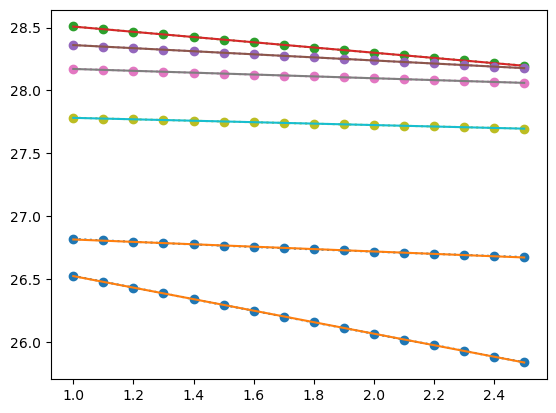

In [7]:
# And plot to see that they match
for f in 'ugrizy':
    plt.plot(airmasses, zp[f], marker='o', linestyle=':')
    plt.plot(airmasses, intercept[f] + slope[f] * (airmasses - 1))

In [8]:
# Just check that exposure time is as linear as expected (-2.5 * np.log10(exptime))
slope = {}
intercept = {}
for f in 'ugrizy':
    slope[f], intercept[f], r_value, p_value, std_err = stats.linregress((np.log10(exptimes)), zpt[f])

print(slope)
print(intercept)

{'u': 2.4999999999999996, 'g': 2.499999999999998, 'r': 2.4999999999999982, 'i': 2.5, 'z': 2.500000000000001, 'y': 2.4999999999999987}
{'u': 26.524236651926522, 'g': 28.508375123264223, 'r': 28.360837796224622, 'i': 28.171396169001046, 'z': 27.78226401325628, 'y': 26.817818872890953}


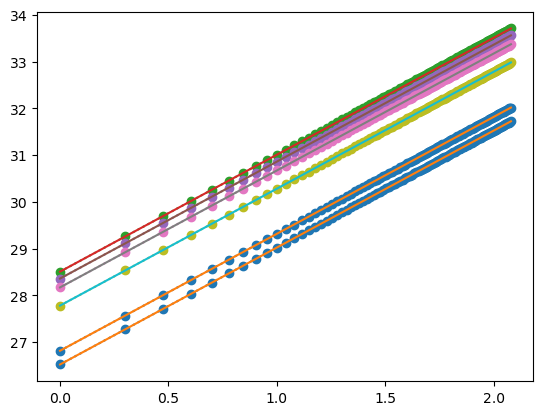

In [9]:
for f in 'ugrizy':
    plt.plot(np.log10(exptimes), zpt[f], marker='o', linestyle=':')
    plt.plot(np.log10(exptimes), intercept[f] + slope[f] * (np.log10(exptimes)))

In [10]:
# Make a nice dictionary to paste in below 
dict(pd.DataFrame(zp, index=airmasses).loc[1.0])

{'u': 26.524236651926522,
 'g': 28.508375123264223,
 'r': 28.36083779622462,
 'i': 28.17139616900105,
 'z': 27.78226401325628,
 'y': 26.817818872890957}

In [11]:
def return_zeropoint(band: str, airmass: float, exptime: float=1) -> float:
    extinction_coeff = {'u': -0.45815823969467745, 'g': -0.20789273881603035, 'r': -0.12233514157672552, 'i': -0.07387773563152214, 'z': -0.0573260392897174, 'y': -0.09549137502152871}
    zeropoint_X1 = {'u': 26.52229760811932, 'g': 28.50754554409417, 'r': 28.360365503331952, 'i': 28.170373076693625, 'z': 27.781368851776005, 'y': 26.813708013594344} 
    
    return zeropoint_X1[band] + extinction_coeff[band] * (airmass - 1) + 2.5 * np.log10(exptime)

In [12]:
# Hardware only 
phot_params = pt.PhotometricParameters(exptime=1, nexp=1, gain=1.0)
exptimes = np.arange(1, 120.5, 1)
x = 1.0
zpt = {}
for f in 'ugrizy':
    zpt[f] = []
    for t in exptimes:
        phot_params = pt.PhotometricParameters(exptime=t, nexp=1, gain=1.0)
        zpt[f].append(hardware[f].calc_zp_t(phot_params))
    zpt[f] = np.array(zpt[f])

In [13]:
for f in 'ugrizy':
    print(f"'{f}': {zp[f][0]},")

'u': 26.524236651926522,
'g': 28.508375123264223,
'r': 28.36083779622462,
'i': 28.17139616900105,
'z': 27.78226401325628,
'y': 26.817818872890957,


In [14]:
# Hardware only is appropriate for skybrightness. The location on the sky is included in the *generation* of the value.
def return_zeropoint_hardware(band: str, exptime: float=1) -> float:
    zeropoint = {'u': 26.99435242519598,
                 'g': 28.72132437054738,
                'r': 28.487206668180864,
                'i': 28.267160381353793,
                'z': 27.850681356053688,
                'y': 26.988827459758397}
    return zeropoint[band] + 2.5 * np.log10(exptime)

In [15]:
# Repeat but for ITL and E2V average sensor curves

defaultDirs = st.setDefaultDirs()
defaultDirs['detector'] = defaultDirs['detector'].replace('/joint_minimum', '/itl')
print(defaultDirs)

airmasses = np.arange(1.0, 2.6, 0.1).round(2)

# Build system and hardware at all airmasses in the standard atmosphere set
system = {}
for x in airmasses:
    atmos = st.readAtmosphere(os.path.join(get_data_dir(), 'throughputs', 'atmos'), atmosFile=f'atmos_{x*10 :.0f}_aerosol.dat')
    h, s = st.buildHardwareAndSystem(defaultDirs, addLosses=True,  atmosphereOverride=atmos)
    system[x] = s
hardware = h

phot_params = pt.PhotometricParameters(exptime=1, nexp=1, gain=1.0)

zp = {}
for f in 'ugrizy':
    zp[f] = []
    for x in airmasses:
        zp[f].append(system[x][f].calc_zp_t(phot_params))
    zp[f] = np.array(zp[f])

slope = {}
intercept = {}
for f in 'ugrizy':
    slope[f], intercept[f], r_value, p_value, std_err = stats.linregress((airmasses-1), zp[f])
slope, intercept

zph = {}
for f in 'ugrizy':
    zph[f] = hardware[f].calc_zp_t(phot_params)

print(slope)
print(intercept)
print(zph)


{'detector': '/Users/lynnej/lsst_repos/syseng_throughputs/components/camera/detector/itl', 'lens1': '/Users/lynnej/lsst_repos/syseng_throughputs/components/camera/lens1', 'lens2': '/Users/lynnej/lsst_repos/syseng_throughputs/components/camera/lens2', 'lens3': '/Users/lynnej/lsst_repos/syseng_throughputs/components/camera/lens3', 'filters': '/Users/lynnej/lsst_repos/syseng_throughputs/components/camera/filters', 'mirror1': '/Users/lynnej/lsst_repos/syseng_throughputs/components/telescope/mirror1', 'mirror2': '/Users/lynnej/lsst_repos/syseng_throughputs/components/telescope/mirror2', 'mirror3': '/Users/lynnej/lsst_repos/syseng_throughputs/components/telescope/mirror3', 'atmosphere': '/Users/lynnej/lsst_repos/syseng_throughputs/siteProperties'}
{'u': -0.45815223255080606, 'g': -0.20789245761381037, 'r': -0.12233512060667238, 'i': -0.07387767800064417, 'z': -0.05739100372986528, 'y': -0.09474605376660676}
{'u': 26.52231025834397, 'g': 28.507547620761827, 'r': 28.360365812523426, 'i': 28.17

In [16]:
def return_zeropoint_itl(band: str, airmass: float, exptime: float=1) -> float:
    extinction_coeff = {'u': -0.45815223255080606, 'g': -0.20789245761381037, 'r': -0.12233512060667238, 'i': -0.07387767800064417, 'z': -0.05739100372986528, 'y': -0.09474605376660676}
    zeropoint_X1 = {'u': 26.52231025834397, 'g': 28.507547620761827, 'r': 28.360365812523426, 'i': 28.170380673108845, 'z': 27.796728189989665, 'y': 26.870922441512732}
    
    return zeropoint_X1[band] + extinction_coeff[band] * (airmass - 1) + 2.5 * np.log10(exptime)

def return_zeropoint_hardware_itl(band: str, exptime: float=1) -> float:
    zeropoint = {'u': 26.994361876151476, 'g': 28.721326283280213, 'r': 28.487206961551088, 'i': 28.26716792192087, 'z': 27.86618994188104, 'y': 27.04446387553851}
    return zeropoint[band] + 2.5 * np.log10(exptime)

In [17]:
# Repeat but for ITL and E2V average sensor curves

defaultDirs = st.setDefaultDirs()
defaultDirs['detector'] = defaultDirs['detector'].replace('/joint_minimum', '/e2v')
print(defaultDirs)

airmasses = np.arange(1.0, 2.6, 0.1).round(2)

# Build system and hardware at all airmasses in the standard atmosphere set
system = {}
for x in airmasses:
    atmos = st.readAtmosphere(os.path.join(get_data_dir(), 'throughputs', 'atmos'), atmosFile=f'atmos_{x*10 :.0f}_aerosol.dat')
    h, s = st.buildHardwareAndSystem(defaultDirs, addLosses=True,  atmosphereOverride=atmos)
    system[x] = s
hardware = h

phot_params = pt.PhotometricParameters(exptime=1, nexp=1, gain=1.0)

zp = {}
for f in 'ugrizy':
    zp[f] = []
    for x in airmasses:
        zp[f].append(system[x][f].calc_zp_t(phot_params))
    zp[f] = np.array(zp[f])

slope = {}
intercept = {}
for f in 'ugrizy':
    slope[f], intercept[f], r_value, p_value, std_err = stats.linregress((airmasses-1), zp[f])
slope, intercept

zph = {}
for f in 'ugrizy':
    zph[f] = hardware[f].calc_zp_t(phot_params)

print(slope)
print(intercept)
print(zph)

{'detector': '/Users/lynnej/lsst_repos/syseng_throughputs/components/camera/detector/e2v', 'lens1': '/Users/lynnej/lsst_repos/syseng_throughputs/components/camera/lens1', 'lens2': '/Users/lynnej/lsst_repos/syseng_throughputs/components/camera/lens2', 'lens3': '/Users/lynnej/lsst_repos/syseng_throughputs/components/camera/lens3', 'filters': '/Users/lynnej/lsst_repos/syseng_throughputs/components/camera/filters', 'mirror1': '/Users/lynnej/lsst_repos/syseng_throughputs/components/telescope/mirror1', 'mirror2': '/Users/lynnej/lsst_repos/syseng_throughputs/components/telescope/mirror2', 'mirror3': '/Users/lynnej/lsst_repos/syseng_throughputs/components/telescope/mirror3', 'atmosphere': '/Users/lynnej/lsst_repos/syseng_throughputs/siteProperties'}
{'u': -0.4600735940453953, 'g': -0.20651340321330425, 'r': -0.12276192263131014, 'i': -0.07398443681400534, 'z': -0.057334002964289726, 'y': -0.095496483868828}
{'u': 26.58989678516041, 'g': 28.567959743207357, 'r': 28.44712188941494, 'i': 28.19470

In [18]:
def return_zeropoint_e2v(band: str, airmass: float, exptime: float=1) -> float:
    extinction_coeff = {'u': -0.4600735940453953, 'g': -0.20651340321330425, 'r': -0.12276192263131014, 'i': -0.07398443681400534, 'z': -0.057334002964289726, 'y': -0.095496483868828}
    zeropoint_X1 = {'u': 26.58989678516041, 'g': 28.567959743207357, 'r': 28.44712188941494, 'i': 28.19470048013101, 'z': 27.7817595301949, 'y': 26.813791858927964}
    
    return zeropoint_X1[band] + extinction_coeff[band] * (airmass - 1) + 2.5 * np.log10(exptime)

def return_zeropoint_hardware_e2v(band: str, exptime: float=1) -> float:
    zeropoint = {'u': 27.063967445283826, 'g': 28.78030646345493, 'r': 28.574328242939043, 'i': 28.291563456601306, 'z': 27.85108207854988, 'y': 26.988912028019346}

    return zeropoint[band] + 2.5 * np.log10(exptime)

In [19]:
# Convert skybrightness prediction mag/sq arcseconds into counts per pixel
zp = return_zeropoint_hardware('i', 30)
mag = 20.463
platescale = phot_params.platescale
np.power(10, (mag-zp)/-2.5) * platescale**2

1587.981353754498

In [20]:
platescale

0.2